# IMDB 영화 리뷰 감성 분석 - LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
import warnings
warnings.filterwarnings('ignore')

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X_train.shape, X_test.shape, y_train.shape

17473536/17464789 [==============================] - 0s 0us/step


((25000,), (25000,), (25000,))

In [3]:
print('등장한 단어수', len(imdb.get_word_index()))
print('리뷰 최대 길이', max(len(s) for s in X_train))
print('리뷰 평균 길이', sum(map(len, X_train)) / len(X_train))

1654784/1641221 [==============================] - 0s 0us/step
등장한 단어수 88584
리뷰 최대 길이 2494
리뷰 평균 길이 238.71364


### LSTM으로 IMDB 리뷰 감성 분석
- 단어 빈도수: 10,000 (총 88,584)
- 문장의 단어수: 500 (최대 2,494)
- test data중 40%(10,000개)는 검증용으로

In [4]:
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)
X_train.shape, X_test.shape, y_train.shape

((25000,), (25000,), (25000,))

In [7]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((25000, 500), (25000, 500))

In [8]:
from sklearn.model_selection import train_test_split
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, stratify=y_test, test_size=0.4, random_state=seed
)
X_test.shape, X_valid.shape, y_test.shape, y_valid.shape

((15000, 500), (10000, 500), (15000,), (10000,))

- LSTM model
    - embedding dim: 100
    - hidden_units: 128

In [9]:
model = Sequential([ 
    Embedding(10000, 100, input_length=max_len),
    LSTM(128, activation='tanh'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])

model_path = 'best-imdb-lstm.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [11]:
hist = model.fit(
    X_train, y_train, epochs=30, batch_size=64, 
    validation_data=[X_valid, y_valid],
    callbacks=[mc, es]
)

Epoch 1/30
391/391 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.7543
Epoch 1: val_loss improved from inf to 0.35033, saving model to best-imdb-lstm.h5
391/391 [==============================] - 46s 101ms/step - loss: 0.4874 - accuracy: 0.7543 - val_loss: 0.3503 - val_accuracy: 0.8522
Epoch 2/30
391/391 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.8924
Epoch 2: val_loss improved from 0.35033 to 0.31570, saving model to best-imdb-lstm.h5
391/391 [==============================] - 39s 99ms/step - loss: 0.2722 - accuracy: 0.8924 - val_loss: 0.3157 - val_accuracy: 0.8653
Epoch 3/30
391/391 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9161
Epoch 3: val_loss did not improve from 0.31570
391/391 [==============================] - 39s 99ms/step - loss: 0.2220 - accuracy: 0.9161 - val_loss: 0.3759 - val_accuracy: 0.8275
Epoch 4/30
391/391 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9364
E

In [12]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

469/469 [==============================] - 18s 37ms/step - loss: 0.3141 - accuracy: 0.8699


[0.31407594680786133, 0.8699333071708679]

- 학습과정 시각화

In [13]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

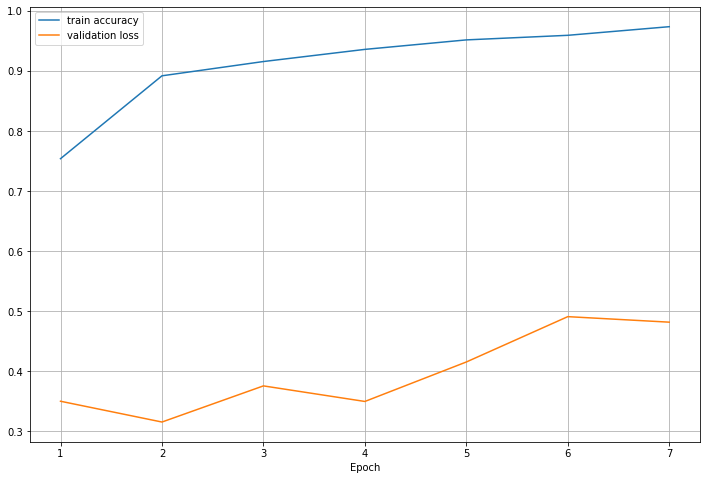

In [14]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.xlabel('Epoch')
plt.grid(), plt.legend()
plt.show()